## 1.5 Hidden Layer Stabilization

이번 실습에서는 Batch Normalization과 Layer Normalization과 같이 Hidden layer의 statistics을 안정화 시켜 전체적으로 학습을 안정시키는 방법에 대해서 알아보고자 합니다. 

![image.png](images/03_dropout.png)

In [ ]:
import math
import random 

import tensorflow as tf
import numpy as np 

seed = 1
random.seed(seed)
np.random.seed(seed=seed)
tf.random.set_random_seed(seed)

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape([-1, 28 * 28]) 
x_test = x_test.reshape([-1, 28 * 28])

m = np.random.randint(0, high=60000, size=1100, dtype=np.int64)
x_train = x_train[m]
y_train = y_train[m]

i = np.arange(1100)
np.random.shuffle(i)
x_train = x_train[i]
y_train = y_train[i]

x_valid = x_train[:100]
y_valid = y_train[:100]

x_train = x_train[100:]
y_train = y_train[100:]

x = tf.placeholder(tf.float32, [None, 28 * 28])
y = tf.placeholder(tf.int32, [None])

n_units = [28 * 28, 512, 512, 10]

weights, biases = [], []
for i, (n_in, n_out) in enumerate(zip(n_units[:-1], n_units[1:])):
    stddev = math.sqrt(2 / n_in) # Kaiming He Initialization
    weight = tf.Variable(tf.random.truncated_normal([n_in, n_out], mean=0, stddev=stddev))
    bias = tf.Variable(tf.zeros([n_out]))
    weights.append(weight)
    biases.append(bias)

우리는 이번 실습에서 Batch Normalization을 사용하는 방법에 대해서 알아보고자 합니다. 
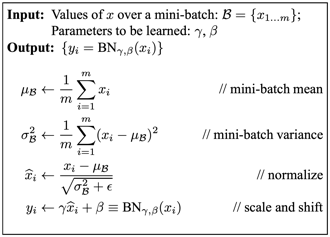
두 줄만 추가하면 Batch Normalization을 사용할 수 있습니다.
먼저 training 여부를 알려주는 placeholder를 추가해줍니다. BN 안에서 학습되는 파라미터들이 있기 때문에, BN Layer에게 training 인지 아닌지 알려주는 프로세스가 필요합니다. 

In [ ]:
training = tf.placeholder(tf.bool)

추가적으로 추가해야 하는 코드는 activation을 통과하기 전에 Batch Normalization Layer를 추가하는 일입니다.

In [ ]:
layer = x 
for i, (weight, bias) in enumerate(zip(weights, biases)):
    layer = tf.matmul(layer, weight) + bias
    if i < len(weights) - 1:
        layer = tf.keras.layers.BatchNormalization()(layer, training=training)
        layer = tf.nn.tanh(layer)        
y_hat = layer

다시 다른 부분들은 이전 실습과 동일하게 진행해 줍니다.

In [ ]:
y_hot = tf.one_hot(y, 10)
costs = tf.nn.softmax_cross_entropy_with_logits_v2(
        labels=y_hot, logits=y_hat)
cross_entropy_loss = tf.reduce_mean(costs)
loss = cross_entropy_loss

accuracy = tf.count_nonzero(
        tf.cast(tf.equal(tf.argmax(y_hot, 1), tf.argmax(y_hat, 1)),
                tf.int64)) / tf.cast(tf.shape(y_hot)[0], tf.int64)

extra_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_ops):
    optimizer = tf.train.AdamOptimizer(1e-3)
    train_op = optimizer.minimize(loss)
    
gpu_options = tf.GPUOptions()
gpu_options.allow_growth = True
session = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
session.run(tf.global_variables_initializer())

training과 inference를 수행할 때에 training 여부를 알려주는 placeholder에 value를 feed해줘야 합니다. 

In [ ]:
max_valid_epoch_idx = 0
max_valid_accuracy = 0.0
final_test_accuracy = 0.0
for epoch_idx in range(1, 1000 + 1):
    session.run(
            train_op,
            feed_dict={
                x: x_train,
                y: y_train,
                training: True
            })
    
    if epoch_idx % 10 == 0:
        train_loss_value, train_accuracy_value = session.run(
            [loss, accuracy],
            feed_dict={
                x: x_train,
                y: y_train,
                training: False
            })
        
        valid_loss_value, valid_accuracy_value = session.run(
            [loss, accuracy],
            feed_dict={
                x: x_valid,
                y: y_valid,
                training: False
            })
            
        test_loss_value, test_accuracy_value = session.run(
            [loss, accuracy],
            feed_dict={
                x: x_test,
                y: y_test,
                training: False
            })

        print(epoch_idx, '%.4f' % train_loss_value, '%.4f' % valid_loss_value, '%.4f' % test_loss_value, '%.4f' % train_accuracy_value, '%.4f' % valid_accuracy_value, '%.4f' % test_accuracy_value)
        
        if max_valid_accuracy < valid_accuracy_value:
            max_valid_accuracy = valid_accuracy_value 
            max_valid_epoch_idx = epoch_idx
            final_test_accuracy = test_accuracy_value
            
    # Early Stop
    if max_valid_epoch_idx + 100 < epoch_idx:
        break
        
print(final_test_accuracy)

88.05% -> 75.92% 로 성능이 상당 부분 저하된 것을 확인할 수 있습니다.
수업시간에도 배웠듯, 모든 정규화가 잘 작동하는 것은 아닙니다. 아키텍쳐마다 좋은 정규화 방식이 다를 수 있습니다.
BN은 어제 수업시간에 배운 CNN에 적용할 때 좋은 성능을 나타내는 것으로 알려져 있습니다. MLP에는 적용하면 많은 경우 성능이 저하됩니다. Layer Normalization의 경우에는 RNN 모델에 적용할 때 좋은 성능을 나타냅니다. 

### 연습 문제

Q1. Batch Normalization을 제거하고 tf.contrib.layers.layer_norm를 이용해 Layer Normalization을 적용해봅시다. 
(힌트는 [여기](01_05_hidden_layer_stabilization_Q1_hint.txt)에서 확인하실 수 있습니다.)
(정답은 [여기](01_05_hidden_layer_stabilization_Q1_answer.txt)에서 확인하실 수 있습니다.)

Q2. (도전과제)Instance Normalization, Group Normalization을 적용해봅시다. 

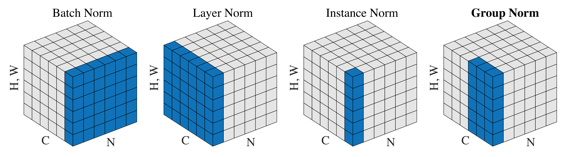

주의사항! 코드를 수정한 이후에는 Kernel > Restart & Run All 을 통해 네트워크를 처음부터 다시 학습시켜 주세요. 

### 다음 실습

이제 다음 [실습](01_06_dropout.ipynb)에서는 Dropout을 적용하는 방법에 대해서 실습해봅니다. 